In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from data import get_data, get_numpy_data
from rbm import RBM
from vae import VAE
from pca import *

In [2]:
BATCH_SIZE = 64
train_dataset, test_dataset = get_data()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [3]:
VISIBLE_UNITS = 784
HIDDEN_UNITS = 100
CD_K = 2
EPOCHS = 50

In [4]:
rbm = RBM(num_visible=VISIBLE_UNITS, num_hidden=HIDDEN_UNITS, k=CD_K, use_cuda=False)
pbar = tqdm(total=EPOCHS)
for epoch in range(EPOCHS):
    epoch_error = 0.0

    for batch, _ in train_loader:
        batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
        batch_error = rbm.contrastive_divergence(batch)
        epoch_error += batch_error

    pbar.set_description('Epoch Error (epoch=%d): %.4f' % (epoch, epoch_error / len(train_loader)))
    pbar.update(1)
pbar.close()

Epoch Error (epoch=49): 1784.0651: 100%|██████████| 50/50 [04:18<00:00,  5.18s/it]


In [5]:
train_features = np.zeros((len(train_dataset), HIDDEN_UNITS))
train_labels = np.zeros(len(train_dataset))
test_features = np.zeros((len(test_dataset), HIDDEN_UNITS))
test_labels = np.zeros(len(test_dataset))

for i, (batch, labels) in enumerate(train_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    train_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    train_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

for i, (batch, labels) in enumerate(test_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    test_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    test_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

clf = LogisticRegression()
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)
print('Result: {:.4%}'.format(np.mean(predictions == test_labels)))

Result: 93.4500%


/Users/mccourt/anaconda3/envs/10716-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


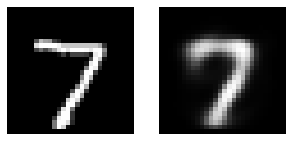

In [26]:
sample_data = next(iter(test_loader))[0]
_, _, sample_rbm, _, _ = rbm.sample_k(sample_data.view(BATCH_SIZE, VISIBLE_UNITS))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))
ax1.imshow(sample_data.view(BATCH_SIZE, 28, 28)[0], cmap='gray')
ax1.axis('off')
ax2.imshow(sample_rbm.view(BATCH_SIZE, 28, 28)[0], cmap='gray')
ax2.axis('off')
plt.show()

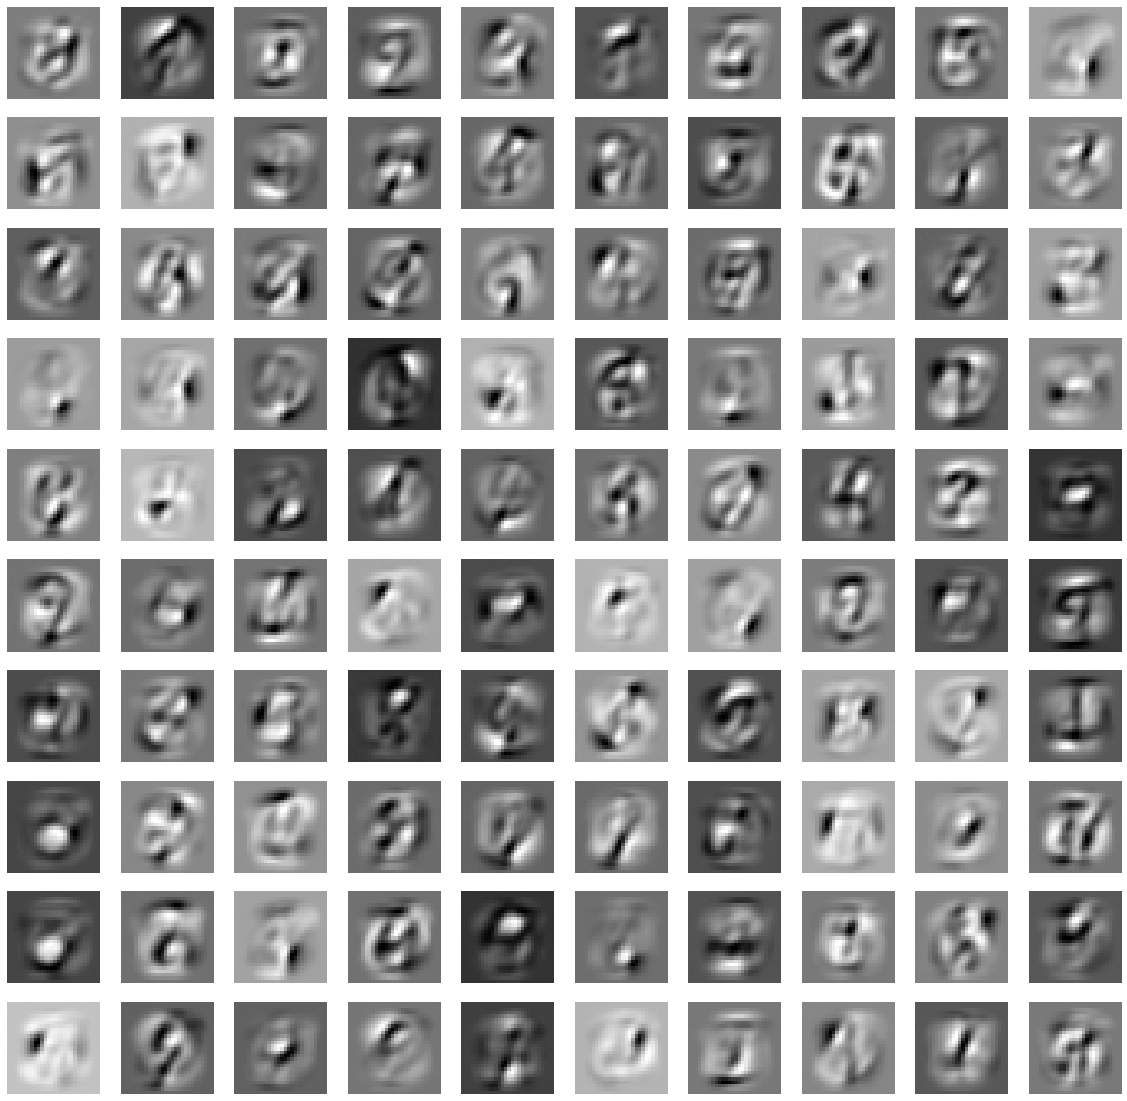

In [25]:
rbm_weights = rbm.weights.transpose(0, 1).view(-1, 28, 28).numpy()
f, axs = plt.subplots(10, 10, figsize=(20, 20))
for ax, w in zip(axs.flatten(), rbm_weights):
    ax.imshow(w, cmap='gray')
    ax.axis('off')
plt.show()

In [21]:
vae = VAE(z_dim=HIDDEN_UNITS)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

pbar = tqdm(total=EPOCHS)
for epoch in range(EPOCHS):
    for batch, _ in train_loader:
        batch = batch.view(len(batch), VISIBLE_UNITS)
        recon_images, mu, logvar = vae(batch)
        loss = loss_fn(recon_images, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description("Epoch Loss: {:.3f}".format(loss / BATCH_SIZE))
    pbar.update(1)
pbar.close()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/mccourt/anaconda3/envs/10716-project/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch Loss: 53.236: 100%|██████████| 50/50 [11:17<00:00, 13.55s/it] 


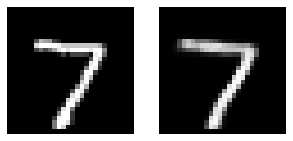

In [24]:
sample_vae, _, _ = vae(sample_data.view(BATCH_SIZE, VISIBLE_UNITS))
sample_vae = sample_vae.detach()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))
ax1.imshow(sample_data.view(BATCH_SIZE, 28, 28)[0], cmap='gray')
ax1.axis('off')
ax2.imshow(sample_vae.view(BATCH_SIZE, 28, 28)[0], cmap='gray')
ax2.axis('off')
plt.show()

In [23]:
train_features = np.zeros((len(train_dataset), HIDDEN_UNITS))
train_labels = np.zeros(len(train_dataset))
test_features = np.zeros((len(test_dataset), HIDDEN_UNITS))
test_labels = np.zeros(len(test_dataset))

for i, (batch, labels) in enumerate(train_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    _, mu, logvar = vae.forward(batch)
    vae.reparameterize(mu, logvar)
    train_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = vae.reparameterize(mu, logvar).detach().cpu().numpy()
    train_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

for i, (batch, labels) in enumerate(test_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    _, mu, logvar = vae.forward(batch)
    test_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = vae.reparameterize(mu, logvar).detach().cpu().numpy()
    test_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

clf = LogisticRegression()
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)
print('Result: {:.4%}'.format(np.mean(predictions == test_labels)))

Result: 86.6900%


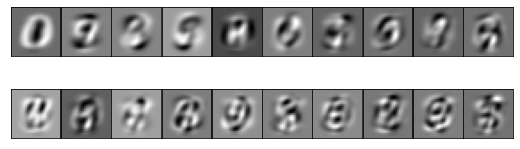

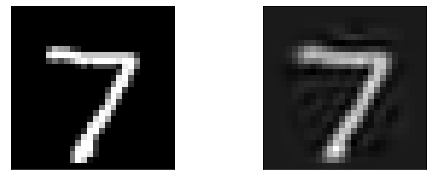

In [27]:
numpy_data = get_numpy_data()
pca_model = build_pca(numpy_data[0], HIDDEN_UNITS)
plot_latent_space(pca_model)
reconstruct(numpy_data[2][0].squeeze(), pca_model)

In [32]:
train_X, train_y, test_X, test_y = numpy_data
clf = LogisticRegression()
clf.fit(pca_model.transform(train_X.reshape((-1, 784))), train_labels)
predictions = clf.predict(pca_model.transform(test_X.reshape((-1, 784))))
print('Result: {:.4%}'.format(np.mean(predictions == test_labels)))



Result: 92.1700%


/Users/mccourt/anaconda3/envs/10716-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
